In [8]:
%matplotlib widget

In [9]:
import mne
import os
import pandas as pd

# --- Define the correct paths ---
subject = 'sub-01'
session = 'ses-01'
run = 'run-01'
task = 'task-para1'

eeg_file_name = f'{subject}_{session}_{task}_{run}_eeg.edf'
events_file_name = f'{subject}_{session}_{task}_{run}_events.tsv'

eeg_data_path = os.path.join('..', '03_Data', subject, session, 'eeg', eeg_file_name)
events_data_path = os.path.join('..', '03_Data', subject, session, 'eeg', events_file_name)

# --- Load Raw Data ---
raw = mne.io.read_raw_edf(eeg_data_path, preload=True, verbose=False)

# --- THE FIX IS HERE: Set the Montage ---
# We tell MNE to use the standard 10-05 system, which is suitable for high-density caps.
# on_missing='ignore' will skip channels in our data that aren't in the standard montage (like 'Stim').
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, on_missing='ignore')
print("Successfully set standard 10-05 montage.")


# --- Load and Attach Event Annotations ---
events_df = pd.read_csv(events_data_path, sep='\t')
annotations = mne.Annotations(onset=events_df['onset'],
                              duration=events_df['duration'],
                              description=events_df['trial_type'])
raw.set_annotations(annotations)
events, event_id = mne.events_from_annotations(raw, verbose=False)
print("\n--- Event Dictionary ---")
print(event_id)

Successfully set standard 10-05 montage.

--- Event Dictionary ---
{np.str_('event_65329'): 1, np.str_('event_65379'): 2, np.str_('event_65381'): 3, np.str_('event_65480'): 4, np.str_('event_65481'): 5}


Found it! The event code for imagined speech is: 2
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 281 events and 4501 original time points ...
0 bad epochs dropped

Successfully created epochs for 'Imagined Speech':
<Epochs | 281 events (all good), -0.5 – 4 s (baseline off), ~1.20 GiB, data loaded,
 '2': 281>

Plotting the first 5 imagined speech trials...


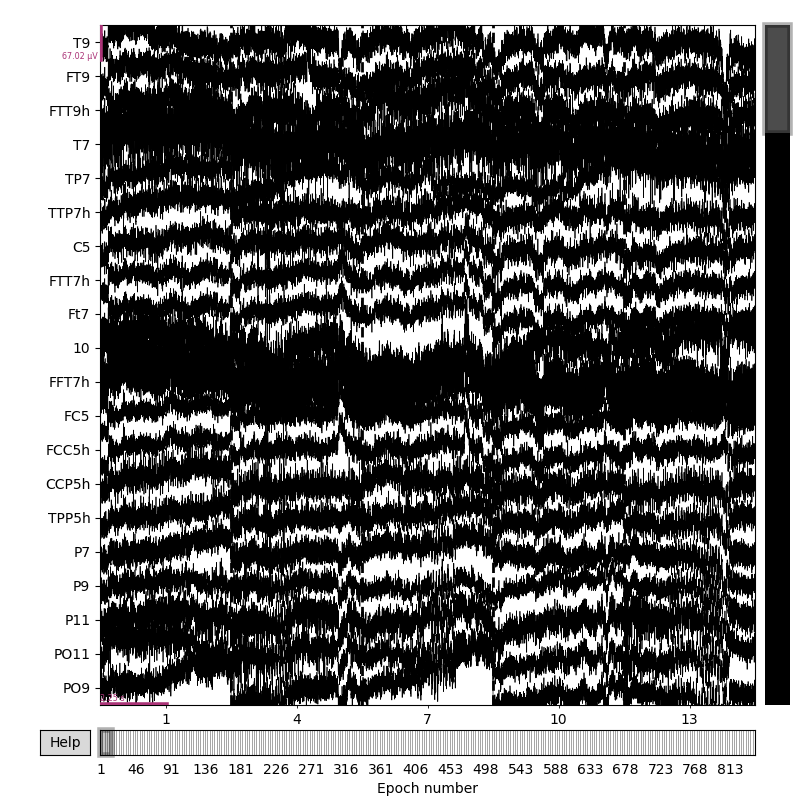

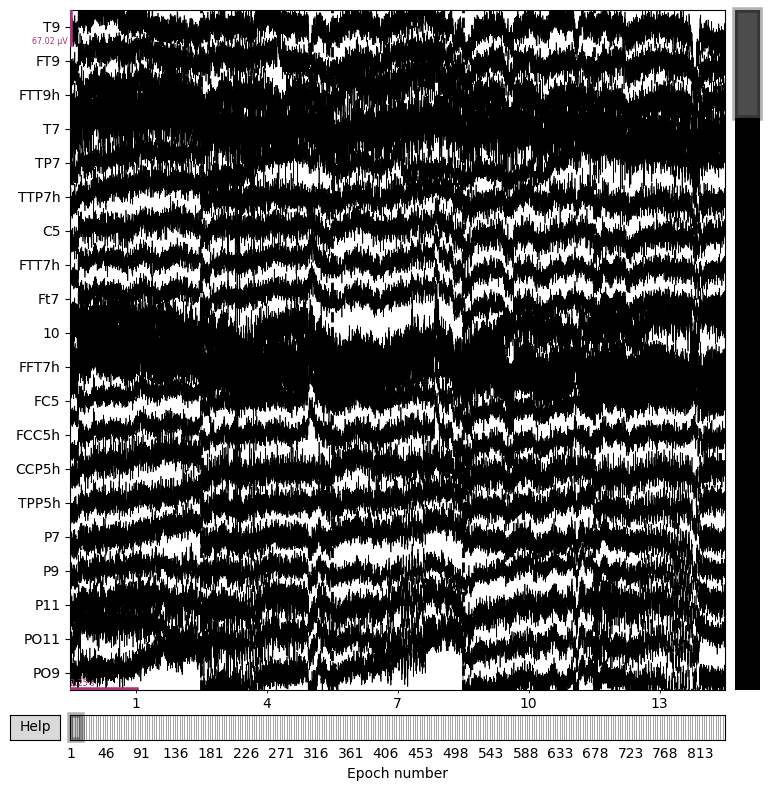

In [10]:
import mne

# From the previous cell's output
event_id = {'event_65329': 1, 'event_65379': 2, 'event_65381': 3, 'event_65480': 4, 'event_65481': 5}

# The "imagined speech" event is 'event_65379'
IMAGINED_SPEECH_EVENT_NAME = 'event_65379'
IMAGINED_SPEECH_EVENT_CODE = event_id[IMAGINED_SPEECH_EVENT_NAME]

print(f"Found it! The event code for imagined speech is: {IMAGINED_SPEECH_EVENT_CODE}")

# The Chisco 2.0 paper states the recall phase is 0.4 * (x + 1) seconds, where x is number of words.
# We will use a generous fixed window for now to capture the data.
tmin, tmax = -0.5, 4.0  # seconds from event onset

# Create epochs: time-locked segments of data around our event of interest
epochs = mne.Epochs(raw, events, event_id=IMAGINED_SPEECH_EVENT_CODE, 
                    tmin=tmin, tmax=tmax, preload=True, baseline=None)

print("\nSuccessfully created epochs for 'Imagined Speech':")
print(epochs)

# Plot the first 5 imagined speech trials to see our isolated data
print("\nPlotting the first 5 imagined speech trials...")
epochs.plot(n_epochs=5, n_channels=20, scalings='auto')

In [11]:
# Downsample the data to 500 Hz to make it more manageable
print(f"Original sampling frequency: {epochs.info['sfreq']} Hz")
epochs.resample(500)
print(f"New sampling frequency: {epochs.info['sfreq']} Hz")

Original sampling frequency: 1000.0 Hz
New sampling frequency: 500.0 Hz


Applying a 1-40 Hz band-pass filter to the epochs...
Filtering complete.

Plotting the first 5 preprocessed imagined speech trials...


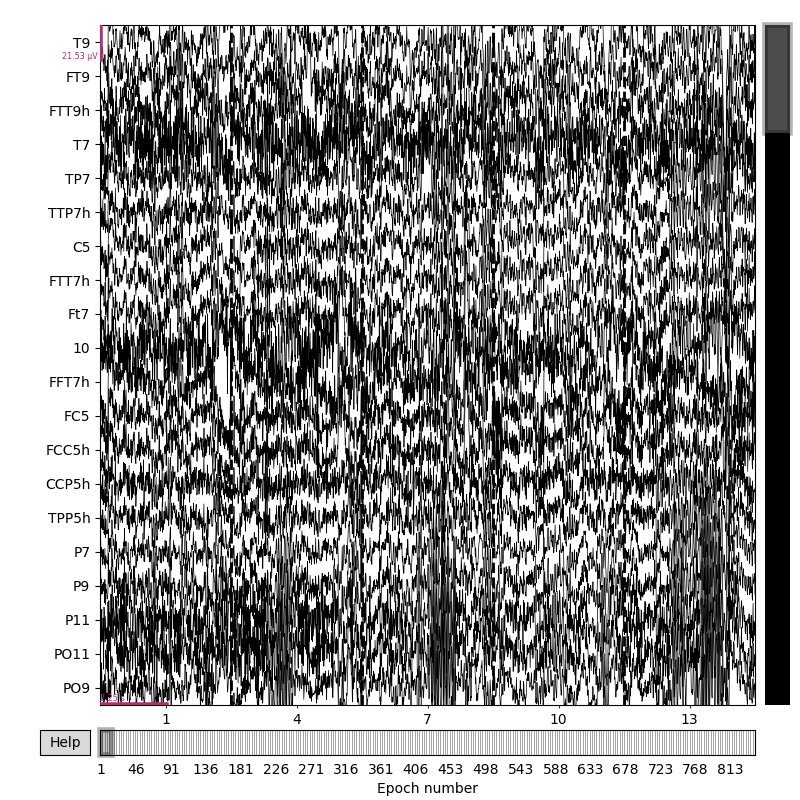

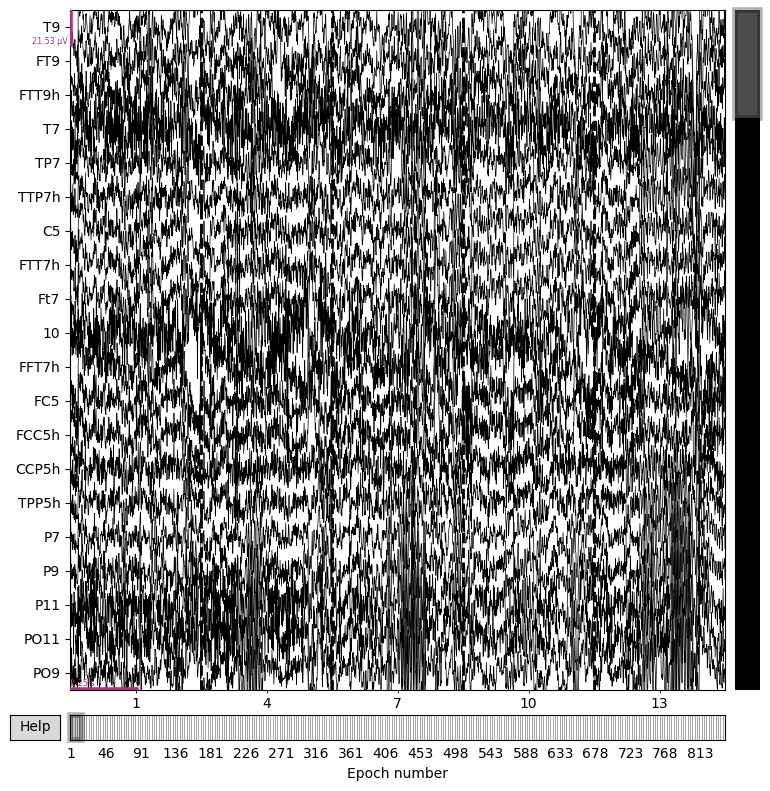

In [12]:
# --- PREPROCESSING STEP 2: BAND-PASS FILTER ---
# Filter from 1-40Hz to isolate the most relevant cognitive frequency bands (Alpha, Beta)
# and remove slow signal drift (<1Hz) and high-frequency muscle/electrical noise (>40Hz).
# This is a standard and critical step for improving signal-to-noise ratio.
print("Applying a 1-40 Hz band-pass filter to the epochs...")
epochs.filter(l_freq=1.0, h_freq=40.0, verbose=False) # verbose=False keeps the output clean
print("Filtering complete.")

# --- Visualize the result ---
print("\nPlotting the first 5 preprocessed imagined speech trials...")
epochs.plot(n_epochs=5, n_channels=20, scalings='auto', title='Preprocessed Imagined Speech Epochs')

In [14]:
# Create a new epochs object containing only the EEG channels.
# This removes the EOG, trigger, and other non-brain channels.
epochs_eeg = epochs.copy().pick('eeg')

print("Created a new epochs object with only EEG channels:")
print(epochs_eeg)

Created a new epochs object with only EEG channels:
<Epochs | 281 events (all good), -0.5 – 3.998 s (baseline off), ~607.9 MiB, data loaded,
 '2': 281>


In [19]:
from mne.preprocessing import ICA

# --- ARTIFACT REMOVAL WITH ICA ---

# 1. Create a copy of the epochs containing ONLY the EEG channels.
# This object has the correct channel locations from the montage.
epochs_eeg = epochs.copy().pick('eeg')
print(f"Created a new epochs object with {len(epochs_eeg.ch_names)} EEG channels for ICA.")


# 2. Set up and fit the ICA model on the clean EEG data.
ica = ICA(n_components=20, random_state=42, max_iter='auto')
print("\nFitting ICA model... (this may take a few minutes)")
ica.fit(epochs_eeg, verbose=False)
print("ICA model fitted successfully.")


# --- 3. Visualize Components (THE FIX) ---
# We now explicitly pass our clean 'epochs_eeg' object to the plotting function.
# This forces it to use the channel locations from 'epochs_eeg' instead of its own internal (and incorrect) list.
print("\nPlotting ICA components...")
ica.plot_components(inst=epochs_eeg)

Created a new epochs object with 126 EEG channels for ICA.

Fitting ICA model... (this may take a few minutes)
ICA model fitted successfully.

Plotting ICA components...


ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
Ft7, 10, TPP5h, P11, PO11, POO11h, FP1, FPz, VEO, HEO, POO12h, PO12, 111, P12